## CLASSIFICATION: UNCLASSIFIED

# Relational (graph-network) data

The goal of this notebook is to show how to read relational data, create a graph (network) from it and explore that graph. 

Relational data consists of any data set in which the *observations* are in *relation* and we want to study those relations. Non-relational data could be movies and features about the movies: year it was produced, movie category, producer, etc. Relational data would be pairs of movies, links between movies that generates a graph. 

In this notebook, we use a graph constructed from a IMDb (Internet Movie Database) data set which contains 120K lists of 249K movies curated by over 44K distinct users. Movies in a list are movies sharing common characteristics according to users.

The nodes of the graph are movies. Two movies share an edge if they are co-listed in a certain number of lists. Edges also have weights: normalized counts of number of lists where the two movies are assigned together. 

In [1]:
#conda install networkx
#pip install python-louvain

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community

## Reading the data

We assume that the network is stored in a file that has at least two columns: *node_id1* and *node_id2* (**vertex1** and **vertex2** in our case) that represents the edges' endpoints. The file can also contain edge attributes: the edge **weight** in our example.

In [2]:
edgefile = '../data/imdb-normalised_edges.csv'
edge_df = pd.read_csv(edgefile)
edge_df.head(3)

,vertex1,vertex2,weight
0,tt0469772,tt0095967,0.2000
1,tt0469772,tt0314062,0.1143
2,tt0469772,tt0116804,0.1143


The nodes can also have attributes stored in a seperate file (movie **title** in our case). We read them here. An important remark is that one of the columns must be a node id (**vertex** in our case) and must correspond with values of *node_id1* and *node_id2* from the edge file.

In [3]:
nodefile = '../data/imdb-normalised_nodes.csv'
node_df = pd.read_csv(nodefile)
node_df.head(3)

,vertex,title
0,tt0469772,Bergman Island
1,tt0493227,Le portrait de petite cossette
2,tt1185416,When in Rome


## Graph Construction from dataframes

Assuming that the edge dataframe has columns **vertex1** and **vertex2** for it's edge 
endpoints and that the edge attributes are the last columns of the dataframe, this is how we construct the graph
from the edge dataframe.

By default, the construction of the graph is undirected (source or target could be interchanged.) To build a directed graph, we must specify to use a directed constructor:
```python
G = nx.from_pandas_dataframe(edge_df, source = 'vertex1', target = 'vertex2', list(edge_df.columns)[2:], create_using = nx.DiGraph())
```
Other data structures can be used to construct a graph. The methods generally start by nx.from...

In [6]:
G = nx.from_pandas_dataframe(edge_df, 'vertex1', 'vertex2', list(edge_df.columns)[2:])

To add the node attributes: we assume that the first column contains the node id and has name **vertex**. The rest of the columns contain the attributes and we use the columns' names as attribute names.

In [7]:
for att in list(node_df.columns)[1:]:
    nx.set_node_attributes(G, att, pd.Series(list(node_df[att]), index=node_df['vertex']).to_dict())

Once you're done constructing your graph, you can export it in various formats and read it directly the next time (with all its attributes attached).
Type nx.write... to get the various formats.

In [8]:
nx.write_graphml(G, '../data/imdb-normalised.graphml')
G = nx.read_graphml('../data/imdb-normalised.graphml')

## Graph Exploration

Here we question the graph and give examples of typical steps one could take to better understand the data set.
* Number of nodes, of edges, of connected components 
* Access node attributes, edge attributes
* Get degree distribution, number of low degree nodes
* Keep the two-core graph
* Plot sections of graphs: small connected components.

We then show an example of how the graph can be broken into pieces (clusters).

In [9]:
n_nodes = len(G)
n_edges = G.size()
n_loops = G.number_of_selfloops()
print('The graph has:',n_nodes , 'edges and', n_edges, 'edges and', n_loops, 'self loops.')

The graph has: 27664 edges and 162888 edges and 0 self loops.


In [10]:
# List attributes of nodes
print('The node attributes are:', list(G.node[G.nodes()[0]].keys()))
print('The edge attributes are:', list(G.edge[G.edges()[0][0]][G.edges()[0][1]].keys()))

The node attributes are: ['title']
The edge attributes are: ['weight']


In [11]:
#Visit first 5 nodes and get their degree
for v in G.nodes()[0:5]:
    print(v, 'with attributes:', G.node[v], 'has degree', nx.degree(G)[v])

tt0469772 with attributes: {'title': 'Bergman Island'} has degree 3
tt0095967 with attributes: {'title': 'Directed by Andrei Tarkovsky'} has degree 2
tt0314062 with attributes: {'title': "Fellini: I'm a Born Liar"} has degree 4
tt0116804 with attributes: {'title': "Krzysztof Kieslowski: I'm So-So..."} has degree 3
tt0493227 with attributes: {'title': 'Le portrait de petite cossette'} has degree 3


In [12]:
#Access edge attributes (first 5)
for e in G.edges()[0:5]:
    v1 = e[0]
    v2 = e[1]
    print(G.node[v1]['title'], '---',  G.node[v2]['title'], ':', G.edge[v1][v2])

Bergman Island --- Directed by Andrei Tarkovsky : {'weight': 0.2}
Bergman Island --- Fellini: I'm a Born Liar : {'weight': 0.1143}
Bergman Island --- Krzysztof Kieslowski: I'm So-So... : {'weight': 0.1143}
Directed by Andrei Tarkovsky --- Krzysztof Kieslowski: I'm So-So... : {'weight': 0.1455}
Fellini: I'm a Born Liar --- Speaking of Bunuel : {'weight': 0.1333}


Here, we count the low degree nodes, we plot the degree distribution and the coreness distribution of the graph. We then extract the 2-core of the graph.

In [32]:
#Low degree nodes
deg0 = sum([d==0 for d in nx.degree(G).values()])
deg1 = sum([d==1 for d in nx.degree(G).values()])
print('G has', deg0, 'isolated nodes and', deg1, 'leaves.')

G has 0 isolated nodes and 5037 leaves.


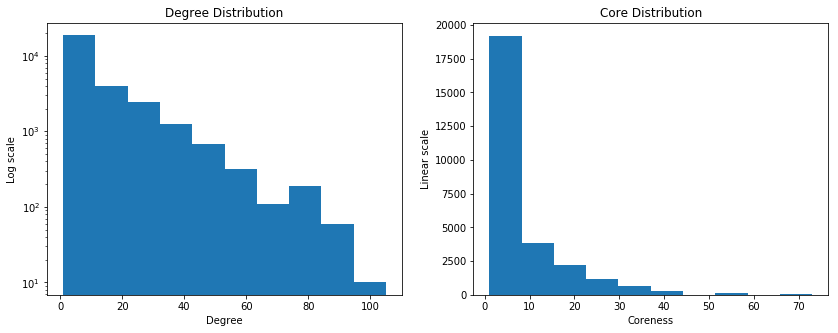

In [33]:
#Plot degree distribution and core distribution
%matplotlib inline
deg = np.array(list(nx.degree(G).values()))
core = np.array(list(nx.find_cores(G).values()))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Log scale')
_=plt.hist(deg, log=True)

plt.subplot(1,2,2)
plt.title('Core Distribution')
plt.xlabel('Coreness')
plt.ylabel('Linear scale')
_=plt.hist(core)

In [34]:
#Keep the 2-core of the graph
G_2core = nx.subgraph(G, [vertex for vertex, core in nx.find_cores(G).items() if core>1])

Many functions exists in nx that compute different features of the graph: check if the graph is connected, get the clustering coefficient, shortest paths between nodes, centrality measures, generate the adjacency matrix, etc.
We give a few examples here but explore the nx. functions to see if what you need is there.

Note that some functions only make sense if the graph is connected: like the diameter and computing all shortest paths for example. We'll give examples later on connected components.

In [47]:
#Get the clustering coefficient of the graph
clust = nx.average_clustering(G)
print('The graph has an average clustering coefficent of', clust, '.')

nx.is_connected(G)

The graph has an average clustering coefficent of 0.45850814783599697 .


False

### Break the graph into pieces

Some functions only run on connected components of the graph (diameter, for example). Here is how you get connected components of a graph.

The graph has 1188 connected components and the largest component contains 23001 nodes.


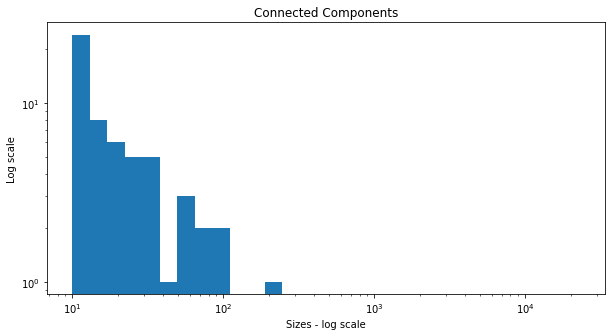

In [24]:
#Sorted list of connected component sizes in decreasing order
connComponents = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('The graph has', len(connComponents), 'connected components and the largest component contains', len(connComponents[0]), 'nodes.')

compSizes = np.array([len(x) for x in connComponents])
MAX = max(compSizes)

fig=plt.figure(figsize=(10,5))
plt.title('Connected Components')
plt.xlabel('Sizes - log scale')
plt.ylabel('Log scale')
plt.hist(compSizes, log=True, bins=10**np.linspace(1, np.log10(MAX), 30))
plt.gca().set_xscale('log')
plt.show()

The visualization of relational data is hard. To use nx plot functions, you first need to extract a subgraph that is small enough and plot that subgraph. Here we plot a small connected component.

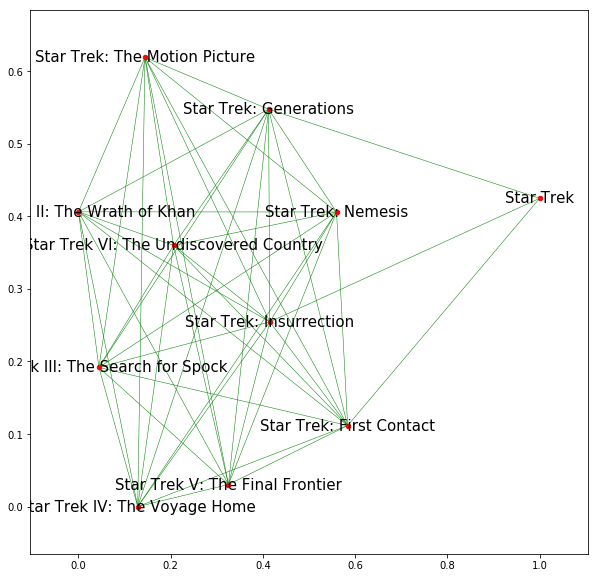

In [48]:
#Plot a small connected component
#Use title as node labels
%matplotlib inline
fig=plt.figure(figsize=(10,10))

pickAcomponentID = 50

comp = connComponents[pickAcomponentID]
subG = G.subgraph(comp)

if(subG.number_of_nodes() < 300):
    pos = nx.spring_layout(subG)
    nx.draw_networkx_nodes(subG, pos, node_size=20)
    nx.draw_networkx_edges(subG, pos, width=.5, edge_color='g')
    nx.draw_networkx_labels(subG, pos, nx.get_node_attributes(subG, 'title'), font_size=15)
    plt.draw()

In [46]:
v = subG.nodes()[0]
print('Access neighbors of', v, 'i.e.', subG.node[v])
G.neighbors(v)

Access neighbors of tt0111280 i.e. {'title': 'Star Trek: Generations'}


['tt0092007',
 'tt0120844',
 'tt0098382',
 'tt0084726',
 'tt0079945',
 'tt0088170',
 'tt0117731',
 'tt0102975',
 'tt0253754',
 'tt0796366']

We give examples of nx functions that work on connected components: diameter and shortest path lengths.

In [49]:
diam = nx.diameter(subG)
print('The diameter of that connected component is', diam, '.')
nx.shortest_path(subG)
nx.shortest_path_length(subG)

The diameter of that connected component is 2 .


{'tt0079945': {'tt0079945': 0,
  'tt0084726': 1,
  'tt0088170': 1,
  'tt0092007': 1,
  'tt0098382': 1,
  'tt0102975': 1,
  'tt0111280': 1,
  'tt0117731': 1,
  'tt0120844': 1,
  'tt0253754': 1,
  'tt0796366': 2},
 'tt0084726': {'tt0079945': 1,
  'tt0084726': 0,
  'tt0088170': 1,
  'tt0092007': 1,
  'tt0098382': 1,
  'tt0102975': 1,
  'tt0111280': 1,
  'tt0117731': 1,
  'tt0120844': 1,
  'tt0253754': 1,
  'tt0796366': 2},
 'tt0088170': {'tt0079945': 1,
  'tt0084726': 1,
  'tt0088170': 0,
  'tt0092007': 1,
  'tt0098382': 1,
  'tt0102975': 1,
  'tt0111280': 1,
  'tt0117731': 1,
  'tt0120844': 1,
  'tt0253754': 1,
  'tt0796366': 2},
 'tt0092007': {'tt0079945': 1,
  'tt0084726': 1,
  'tt0088170': 1,
  'tt0092007': 0,
  'tt0098382': 1,
  'tt0102975': 1,
  'tt0111280': 1,
  'tt0117731': 1,
  'tt0120844': 1,
  'tt0253754': 1,
  'tt0796366': 2},
 'tt0098382': {'tt0079945': 1,
  'tt0084726': 1,
  'tt0088170': 1,
  'tt0092007': 1,
  'tt0098382': 0,
  'tt0102975': 1,
  'tt0111280': 1,
  'tt0117731'

### Looking into the large connected components

For a weighted graph (that is each edge has a weight that represents the strength of the association), graph clustering algorithms in python-louvain tend to be robust and stable. 
For unweighted graph, talk to H4A people. 

In this example, we do have weighted edges. 

In [28]:
largeComp = connComponents[1]
subG_2 = G.subgraph(largeComp)
part = community.best_partition(subG_2, weight='weight')
values = [part.get(node) for node in subG_2.nodes()]

print('The component has', len(subG_2), 'nodes and has been split into', len(set(values)), 'communities.')

The component has 208 nodes and has been split into 9 communities.


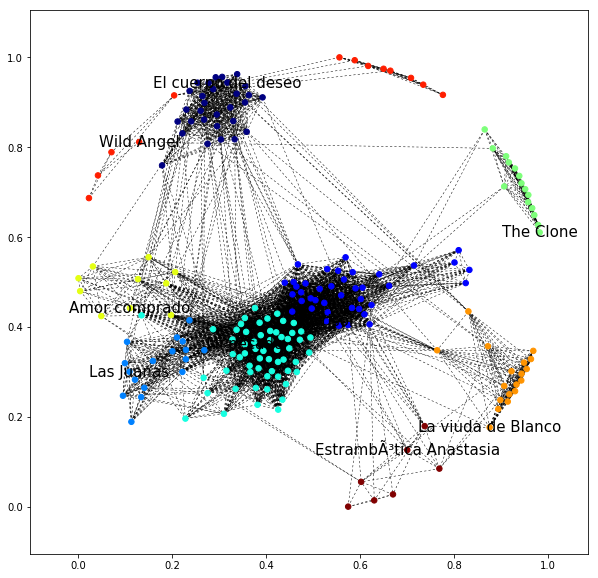

In [29]:
%matplotlib inline
fig=plt.figure(figsize=(10,10))

#Pick one label node per community
community_representative = [values.index(i) for i in range(max(values)+1)]
labels = dict()
for rep in community_representative:
    v = subG_2.nodes()[rep]
    labels[v] = subG_2.node[v]['title']

#Plot the component with different colors for communities
pos = nx.spring_layout(subG_2)
nx.draw_networkx_nodes(subG_2, pos, node_size=30, cmap=plt.get_cmap('jet'), node_color = values)
nx.draw_networkx_edges(subG_2, pos, width=.5, style='dotted')
nx.draw_networkx_labels(subG_2, pos, labels, font_size=15)
plt.draw()